# Bayessian NN: Bayes by Backpropagation

In [1]:
import os
import sys
import math
import time
import random
import tempfile
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
%matplotlib inline
plt.ioff()

dev = torch.device('cuda:0')

PI = torch.Tensor([math.pi]).to(dev)

### Helper methods:

In [3]:
def log_normpdf(x, mu, sigma):
    
    return -0.5*torch.mean(torch.log(2*PI*sigma**2) + ((mu - x)/sigma)**2)

## Define model:

In [4]:
class BBLinear_LR(nn.Module):
    def __init__(self, input_dim, output_dim, prior_pi, prior_sigma1, prior_sigma2, **kwargs):
        super(BBLinear_LR, self).__init__()
        
        self.mu = nn.Parameter(torch.randn(input_dim+1, output_dim))
        self.rho = nn.Parameter(torch.randn(input_dim+1, output_dim))
        
        self.softplus = nn.Softplus()
        
        self.prior_pi = nn.Parameter(torch.Tensor([prior_pi]), requires_grad=False)
        self.prior_sigma1 = nn.Parameter(torch.Tensor([prior_sigma1]), requires_grad=False)
        self.prior_sigma2 = nn.Parameter(torch.Tensor([prior_sigma2]), requires_grad=False)
        
    def forward(self, x):
        
        # Local Reparametrization
        Z_mu = (torch.mm(x, self.mu[1:, :])) + self.mu[0, :]
        
        sigma = self.softplus(self.rho)
        
        Z_sigma = torch.sqrt(torch.mm(x**2, sigma[1:, :]**2) + sigma[0, :]**2)
        
        # Sample
        e = torch.randn_like(Z_mu)
        
        Z = Z_mu + Z_sigma*e

        KL = self.posterior(Z, Z_mu, Z_sigma) - self.prior(x, Z)

        
        return Z, KL
    
    def prior(self, x, Z):
        
        W1 = torch.ones_like(self.mu)*self.prior_sigma1**2
        W2 = torch.ones_like(self.mu)*self.prior_sigma2**2
        
        Z_sigma1 = torch.sqrt(torch.mm(x**2, W1[1:, :]**2) + W1[0, :]**2)
        Z_sigma2 = torch.sqrt(torch.mm(x**2, W2[1:, :]**2) + W2[0, :]**2)
        
        return self.prior_pi*log_normpdf(Z, 0, Z_sigma1) + (1-self.prior_pi)*log_normpdf(Z, 0, Z_sigma2)
        
        
    def posterior(self, Z, Z_mu, Z_sigma):
        return log_normpdf(Z, Z_mu, Z_sigma)

In [5]:
class BBNN_LR(nn.Module):
    def __init__(self, input_dim, output_dim, prior_pi, prior_sigma1, prior_sigma2, hidden_size=[]):
        super(BBNN_LR, self).__init__()
        hs = [input_dim] + hidden_size + [output_dim]
        
        self.layers = nn.ModuleList([BBLinear_LR(inp, out, prior_pi, prior_sigma1, prior_sigma2)
                                     for inp, out in zip(hs[:-1], hs[1:])])
        
    def forward(self, x, n_samples=10):
        
        KL = 0
        Z = 0
        for n in range(n_samples):
            z = x
            for i, layer in enumerate(self.layers):
                if i>0:
                    z = torch.tanh(z)
                z, _KL = layer(z)
                KL += _KL
                
            Z += z
            
        return Z/n_samples, KL/n_samples

In [6]:
class BBLinear(nn.Module):
    def __init__(self, input_dim, output_dim, prior, **kwargs):
        super(BBLinear, self).__init__()
        
        self.mu = nn.Parameter(torch.randn(input_dim+1, output_dim))
        self.rho = nn.Parameter(torch.randn(input_dim+1, output_dim))
        
        self.softplus = nn.Softplus()
        
        self.prior = prior
        
    def forward(self, x):
        
        e = torch.randn_like(self.mu)

        W = self.mu + self.softplus(self.rho)*e

        KL = self.posterior(W) - self.prior(W)

        Z = torch.mm(x, W[1:, :]) + W[0, :]
        
        return Z, KL
        
        
    def posterior(self, W):
        sigma = self.softplus(self.rho)
        return log_normpdf(W, self.mu, sigma)

In [7]:
class BBNN(nn.Module):
    def __init__(self, input_dim, output_dim, prior, hidden_size=[]):
        super(BBNN, self).__init__()
        hs = [input_dim] + hidden_size + [output_dim]
        
        self.layers = nn.ModuleList([BBLinear(inp, out, prior) for inp, out in zip(hs[:-1], hs[1:])])
        
    def forward(self, x, n_samples=10):
        
        KL = 0
        Z = 0
        for n in range(n_samples):
            z = x
            for i, layer in enumerate(self.layers):
                if i>0:
                    z = torch.tanh(z)
                z, _KL = layer(z)
                KL += _KL
                
            Z += z
            
        return Z/n_samples, KL/(n_samples*(i+1))

### Define a prior

In [8]:
sigma1 = np.exp(-1)
sigma2 = np.exp(-7)

pi = 0.5

In [9]:
def prior(X):
    return pi*log_normpdf(X, 0, sigma1) + (1-pi)*log_normpdf(X, 0, sigma2)

In [10]:
# Load data
mnist_dataset = datasets.MNIST(tempfile.gettempdir(), train=True, download=True,
                       transform=transforms.Compose([
                            transforms.ToTensor(),
                        ]))

In [11]:
N = torch.Tensor([len(mnist_dataset)]).to(dev)

## Train a BNN on MNIST

In [12]:
batch_size=128
epochs = 600

train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [19]:
bnn = BBNN(784, 10, prior=prior, hidden_size=[400]).to(dev)

optimizer = torch.optim.Adam(bnn.parameters())
CE = torch.nn.CrossEntropyLoss()

In [20]:
loss = []
KL = []
NLL = []

In [21]:
# Train loop
t0 = time.time()

for e in range(epochs):

    cum_loss = 0
    cum_KL = 0
    cum_NLL = 0
    count = 0
    
    for images, targets in train_loader:
        n = images.shape[0]
        images = images.view(n, -1)
        images = images.to(dev, non_blocking=True)
        targets = targets.to(dev, non_blocking=True)

        preds, _KL = bnn(images, n_samples=1)
        
        _NLL = CE(preds, targets)
        if _NLL != _NLL:
            print(bnn.layers[0].mu[0])
            break
        
        _loss = _NLL + 0.01*_KL

        cum_loss += _loss.item()
        cum_NLL += _NLL.item()
        cum_KL += _KL.item()
        count += 1

        _loss.backward()
        optimizer.step()

    loss.append(cum_loss/count)
    KL.append(cum_KL/count)
    NLL.append(cum_NLL/count)
        
    if e%5 == 4:
        print('epoch: {}, at time: {:.2f}, loss: {:.3e}, NLL: {:.3e}, KL: {:.3e}'.format(
              e, time.time()-t0, loss[-1], NLL[-1], KL[-1]), end='\r')

tensor([-0.2990,  0.8823, -0.4586, -0.8628,  0.5057,  0.0429,  0.1194, -0.7445,
         0.7960, -0.9063,  0.7199,  0.3973,  0.9586, -0.1093, -0.1368,  0.7861,
        -0.8257,  0.5247,  0.7967,  1.0118, -0.1952,  0.6318,  0.7308,  0.4482,
        -0.6291, -0.7171, -0.3250, -0.0102, -0.1063, -0.8866,  0.1477,  0.9303,
         0.2920,  0.0961,  0.6032, -0.0872,  0.9261,  0.0553,  0.6067,  0.4197,
         0.5441,  0.0708,  0.6814, -0.6585,  1.0555,  1.0396,  0.5737, -0.4213,
         1.1489,  0.1498,  0.5547,  0.4437, -0.8762, -0.5441, -0.4255, -0.0017,
         0.6237,  0.8840,  1.0972, -0.4396,  0.3119,  0.8181, -0.1634, -0.1869,
        -0.0080, -0.2896,  0.4800, -0.4243,  0.5176, -0.4984,  0.2064,  0.2944,
        -0.9584, -0.6798,  0.4101, -1.2404,  0.2497,  1.0779, -0.6605, -0.5567,
        -0.4499, -0.3862, -0.2085, -0.2239, -0.1169,  0.3072,  0.9527, -0.7050,
         1.4583,  0.3024,  0.6799,  0.3815,  0.0535, -0.4775,  0.1608,  0.8648,
         0.7874,  0.9385, -0.9043, -0.13

ZeroDivisionError: division by zero

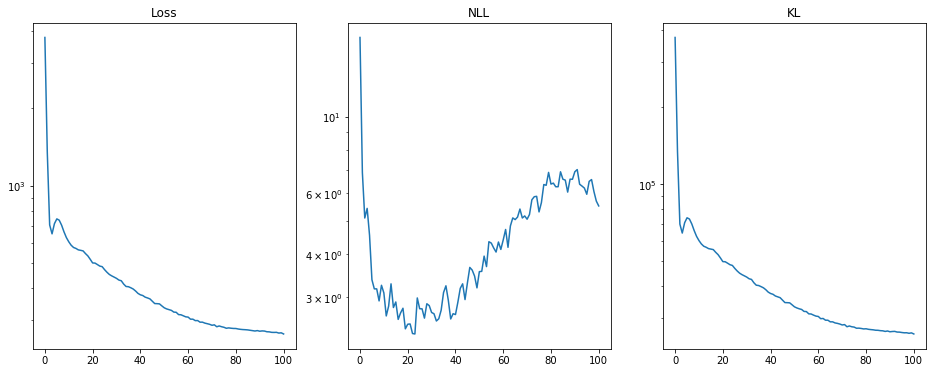

In [22]:
fig, ax_arr = plt.subplots(1, 3, figsize=(16, 6))

ax_arr[0].plot(loss)
ax_arr[0].set_yscale('log')
ax_arr[0].set_title('Loss')


ax_arr[1].plot(NLL)
ax_arr[1].set_yscale('log')
ax_arr[1].set_title('NLL')


ax_arr[2].plot(KL)
ax_arr[2].set_yscale('log')
ax_arr[2].set_title('KL')

plt.show()

In [23]:
bnn.layers[0].rho[0]

tensor([-46.8149, -47.5042, -47.3733, -46.2099, -48.2366, -47.4234, -47.2233,
        -47.6407, -47.2504, -46.5193, -46.6423, -46.4828, -46.0032, -49.1228,
        -47.1782, -47.9530, -47.0485, -48.8458, -47.6589, -47.3568, -49.0676,
        -48.0455, -47.5005, -47.3124, -48.6742, -47.2847, -49.0094, -47.4836,
        -47.1847, -48.1006, -47.7257, -49.0348, -46.8456, -47.9532, -48.5797,
        -47.8925, -47.7386, -48.3672, -46.2891, -47.1860, -48.4665, -50.2445,
        -47.7048, -46.9195, -47.0545, -48.3112, -47.2332, -47.5260, -48.4659,
        -46.0778, -47.2983, -48.0228, -46.5009, -47.3257, -47.0224, -46.2062,
        -49.1960, -46.3701, -47.5213, -48.9017, -47.2775, -47.9160, -47.1926,
        -47.9613, -47.1138, -47.3027, -47.7305, -47.1894, -47.5875, -48.0608,
        -47.1794, -49.2255, -48.0949, -47.4551, -48.0166, -48.2767, -47.7893,
        -48.0013, -48.2572, -47.3148, -46.2073, -47.6521, -49.8272, -48.4639,
        -49.1363, -47.0433, -46.9002, -49.5735, -47.8954, -48.03

In [24]:
bnn.layers[0].softplus(bnn.layers[0].rho[0])

tensor([4.6616e-21, 2.3398e-21, 2.6671e-21, 8.5367e-21, 1.1249e-21, 2.5368e-21,
        3.0988e-21, 2.0413e-21, 3.0160e-21, 6.2652e-21, 5.5402e-21, 6.4982e-21,
        1.0497e-20, 4.6372e-22, 3.2418e-21, 1.4938e-21, 3.6906e-21, 6.1170e-22,
        2.0044e-21, 2.7114e-21, 4.9002e-22, 1.3618e-21, 2.3484e-21, 2.8346e-21,
        7.2620e-22, 2.9141e-21, 5.1937e-22, 2.3885e-21, 3.2208e-21, 1.2887e-21,
        1.8750e-21, 5.0635e-22, 4.5210e-21, 1.4934e-21, 7.9818e-22, 1.5869e-21,
        1.8509e-21, 9.8714e-22, 7.8866e-21, 3.2166e-21, 8.9388e-22, 1.5105e-22,
        1.9146e-21, 4.1987e-21, 3.6685e-21, 1.0441e-21, 3.0682e-21, 2.2895e-21,
        8.9436e-22, 9.7429e-21, 2.8749e-21, 1.3931e-21, 6.3812e-21, 2.7970e-21,
        3.7882e-21, 8.5685e-21, 4.3099e-22, 7.2730e-21, 2.3001e-21, 5.7842e-22,
        2.9353e-21, 1.5501e-21, 3.1954e-21, 1.4814e-21, 3.4574e-21, 2.8621e-21,
        1.8660e-21, 3.2055e-21, 2.1528e-21, 1.3411e-21, 3.2376e-21, 4.1845e-22,
        1.2961e-21, 2.4577e-21, 1.4017e-